# Dependencies

In [1]:
import os
import sys

sys.path.append(os.getcwd().split('notebooks')[0])

from notebooks.utilities.utils import *

Device: cpu


In [2]:
import random
# import wandb
import numpy as np
from dotmap import DotMap

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import sys
from notebooks.utilities.helper_functions import *

from notebooks.tensor_completion_models.CoSTCo import *
from notebooks.tensor_completion_models.CPD import *
from notebooks.tensor_completion_models.tuckER import *
from notebooks.tensor_completion_models.ETC import *

import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import tensorly as tl
from torch.nn.init import xavier_normal_

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, KFold

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


# Load Tensor

### Preliminaries

In [4]:
original_tensor = None
for_queries = False
file = None

### Query Tensors

In [5]:
file = "AND_AND_801"
# file = "AND_OR_801"
# file = "OR_AND_801"
# file = "OR_OR_801"

# file = "AND_AND_distinct_817"
# file = "AND_OR_distinct_817"
# file = "OR_AND_distinct_817"
# file = "OR_OR_distinct_817"


if (file is not None):
    file = 'query_tensors/' + file
    original_tensor = torch.load(f"{meta_data_folder}{file}.pt")

In [6]:
if (original_tensor is not None):
    original_tensor = (original_tensor - original_tensor.min())/(original_tensor.max() - original_tensor.min())
    for_queries = True

### Hyperparameter Tensors

In [7]:
# file = "non_deep/SVM_Dermatology_828"           # trivial but CoSTCo still slightly better than naive
# file = "non_deep/RF_Dermatology_828"            # good one
# file = "non_deep/ET_Dermatology_828"            # good one
# file = "non_deep/DT_Dermatology_828"
# file = "non_deep/KNN_car_evaluation_828"        # pretty good one (~ 4000 cells too)
# file = "non_deep/DT_Spambase_829"               # good one
# file = "non_deep/RF_Spambase_829"               # good one
# file = "non_deep/ET_Spambase_829"               # good one
# file = "non_deep/GB_Spambase_829"               # good one
# file = "non_deep/KNN_Spambase_829"              # trivial but CoSTCo still slightly better than naive

# file = "non_deep/SVM_Biodeg_905"                # pretty decent
# file = "non_deep/SVM_Dermatology_905"           # great !
# file = "non_deep/SVM_Alzheimers_905"              

# file = "non_deep/KNN_Alzheimers_902"            # good one
# file = "non_deep/KNN_Glass_902"                 # eh
# file = "non_deep/KNN_Dermatology_903"           # bad

In [8]:
# original_tensor = torch.stack((torch.load(f"{meta_data_folder}non_deep/DT_Spambase_829.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/RF_Spambase_829.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/ET_Spambase_829.pt"),
#                                torch.load(f"{meta_data_folder}non_deep/GB_Spambase_829.pt")))

# original_tensor = original_tensor[:, :, 0, :, :, :].clone()          # very good one

### Deep Learning Tensors

In [9]:
# file = "deep_learning/FCNN_biodeg_828"              # maybe... (CoSTCo is barely better than naive median)
# file = "deep_learning/FCNN_Dermatology_829"         # good one
# file = "deep_learning/FCNN_glass_902"               # maybe... (CoSTCo is barely better than naive median)

# file = "deep_learning/FCNN_Spambase_902"            # eh
# file = "deep_learning/FCNN_Particle_ID_903_02"      # decent !
# file = "deep_learning/FCNN_Alzheimers_902"          # bad
# file = "deep_learning/FCNN_car_evaluation_903"      # pretty decent
# file = "deep_learning/FCNN_Dermatology_903"         # interesting (good way)

# file = "deep_learning/FCNN_Spambase_905_50"

In [10]:
# original_tensor = torch.stack((torch.load(f"{meta_data_folder}deep_learning/FCNN_Spambase_902.pt"),
#                                torch.load(f"{meta_data_folder}deep_learning/FCNN_Particle_ID_903_02.pt"),
#                                torch.load(f"{meta_data_folder}deep_learning/FCNN_Alzheimers_902.pt"),
#                                torch.load(f"{meta_data_folder}deep_learning/FCNN_car_evaluation_903.pt"),
#                                torch.load(f"{meta_data_folder}deep_learning/FCNN_Dermatology_903.pt")))
# # very nice !

In [11]:
if (file is not None): 
    
    if (original_tensor is None): 
        original_tensor = torch.load(f"{meta_data_folder}{file}.pt")
    
    file = file.split('/')[-1]
    print(f"File Name: {file}")

File Name: AND_AND_801


### Looking at Tensor

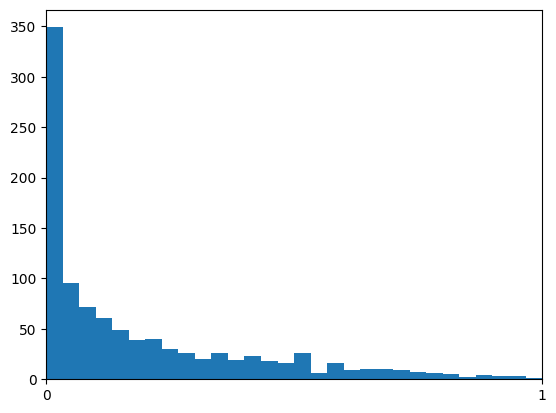

In [12]:
plt.hist([float(x) for x in original_tensor.flatten()], bins = 30)
plt.xlim(0, 1)
plt.xticks([original_tensor.min(), original_tensor.max()])
plt.show()

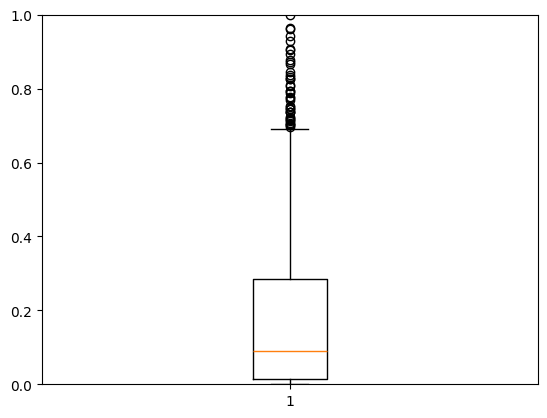

In [13]:
plt.boxplot([float(x) for x in original_tensor.flatten()])
plt.ylim(0, 1)
plt.show()

In [14]:
original_tensor.shape

torch.Size([10, 10, 10])

In [15]:
print(f"Tensor shape: {original_tensor.shape}")
total_cells = 1
for s in original_tensor.shape: total_cells*=s

print(f"{total_cells} total cells in tensor.")

Tensor shape: torch.Size([10, 10, 10])
1000 total cells in tensor.


# Train & Evaluate

### Some Training Configurations

In [16]:
num_epochs = 10000
batch_size = 256
lr = 5e-3
wd = 1e-4
val_size = 0.2

num_iterations = 5

# ranks = [1, 2, 3, 4, 5, 7, 10, 15, 25]
ranks = [None]

# portions = [0.025, 0.05, 0.075, 0.1, 0.15, 0.25]

portions = [0.005, 0.01, 0.02, 0.03, 0.05]

In [17]:
original_tensor_sparse = get_sparse_tensor(t = original_tensor.clone(), portion = 1.0)

### Make Portion Graphs

##### Function

In [18]:
def get_MAEs():
        
        MAEs = list()

        for portion in portions:

                it_MAEs = list()
                
                print(f"Portion {portion} iteration:", end = " ")
                for it in range(1, num_iterations+1):
                        
                        sparse_tensor = get_sparse_tensor(t = original_tensor.clone(),
                                                        portion = portion,
                                                        verbose = False)
                        
                        rank_MAEs = list()
                        for rank in ranks:
                                
                                model_MAEs = list()
        
                                        
# _________________________________________________________________________________________________________________________________________________________________

                                
                                # Naive Tensor Completion Methods
                                
                                model_MAEs += [get_naive_unique_MAE(sparse_tensor = sparse_tensor, 
                                                                original_tensor = original_tensor, 
                                                                random_method = 'sampling')]
                                
                                
# _________________________________________________________________________________________________________________________________________________________________

                                
                                model = train_tensor_completion(model_type = 'cpd',
                                                                sparse_tensor = sparse_tensor,
                                                                rank = 3,
                                                                num_epochs = num_epochs,
                                                                batch_size = batch_size,
                                                                lr = 5e-3,
                                                                wd = wd,
                                                                early_stopping = True,
                                                                flags = 15,
                                                                val_size = 0.2,
                                                                convert_to_cpd = False,
                                                                for_queries = for_queries,
                                                                device = device)
                                
                                model_MAEs += [get_unique_MAE(model = model,
                                                        full_t = original_tensor.clone(),
                                                        sparse_t = sparse_tensor.clone(),
                                                        return_errors = False,
                                                        return_indices = False,
                                                        device = device)]
                                
                                
                                del model  
                                

# _________________________________________________________________________________________________________________________________________________________________

                                
                                model = train_tensor_completion(model_type = 'costco',
                                                                sparse_tensor = sparse_tensor,
                                                                rank = 32,
                                                                num_epochs = num_epochs,
                                                                batch_size = batch_size,
                                                                lr = lr,
                                                                wd = wd,
                                                                early_stopping = True,
                                                                flags = 15,
                                                                val_size = 0.2,
                                                                convert_to_cpd = False,
                                                                for_queries = for_queries,
                                                                device = device)
                                
                                model_MAEs += [get_unique_MAE(model = model,
                                                        full_t = original_tensor.clone(),
                                                        sparse_t = sparse_tensor.clone(),
                                                        return_errors = False,
                                                        return_indices = False,
                                                        device = device)]
                                
                                
                                del model
                                
                
# _________________________________________________________________________________________________________________________________________________________________
                                
                             
                                model = ETC(sparse_tensor = sparse_tensor,
                                        models_type_rank = [
                                                        'cpd.smooth_1', 'cpd.smooth_3', 'cpd.smooth_5', 'cpd.smooth_10'
                                                        ],
                                        
                                        num_splits = 10,
                                        mlp_hidden_dim1 = 128,
                                        agg_func = 'mlp',
                                        dropout_p = 0.0,
                                        dropout_p_before_mlp = 0.0,
                                        lr = lr,
                                        wd = wd,
                                        num_epochs = num_epochs,
                                        batch_size = batch_size,
                                        for_queries = for_queries,
                                        device = device)
                                                        
                                model = train_learned_ensemble(model = model,
                                                                sparse_tensor = sparse_tensor,
                                                                lr = lr,
                                                                wd = wd,
                                                                num_epochs = num_epochs,
                                                                batch_size = batch_size,
                                                                flags = 50,
                                                                early_stopping = True,
                                                                val_size = 0.2,
                                                                device = device)
                                
                                model_MAEs += [get_unique_MAE(model = model,
                                                                full_t = original_tensor.clone(),
                                                                sparse_t = sparse_tensor.clone(),
                                                                return_errors = False,
                                                                return_indices = False,
                                                                device = device)]
                                
                                
                                del model    
 
# _________________________________________________________________________________________________________________________________________________________________

                                
                                rank_MAEs += [model_MAEs]
                                
                        it_MAEs +=[rank_MAEs]

                        if (it == num_iterations): print(it)
                        else: print(it, end = ", ")

                MAEs += [it_MAEs]

        MAEs = np.array(MAEs)

        print("\nAll done!")
        
        return MAEs

##### Display Progress

In [19]:
MAEs = get_MAEs()
original_MAEs = np.array(torch.tensor(MAEs).clone())

Portion 0.005 iteration: 1, 2, 3, 4, 5
Portion 0.01 iteration: 1, 2, 3, 4, 5
Portion 0.02 iteration: 1, 2, 3, 4, 5
Portion 0.03 iteration: 1, 2, 3, 4, 5
Portion 0.05 iteration: 1, 2, 3, 4, 5

All done!


### Which Models to Display

In [20]:
original_labels = [
          'Naive',
          'CPD', 
          'CoSTCo',
          'CPD-S Ensemble',
          ]

In [21]:
model_indices = None

In [22]:
# model_indices = [0, 1, 3, 4, 5, 6]

In [23]:
if (model_indices is not None): 
    
    MAEs = original_MAEs[..., model_indices]
    
    labels = [original_labels[i] for i in model_indices]
    
else:
    
    MAEs = original_MAEs.copy()
    labels = original_labels.copy()

### Display Ranks

In [24]:
if (len(ranks) > 1):

    for i in range(MAEs.shape[-1]):
        
        current_model = MAEs[:, :, :, i]
        
        print(f"{labels[i]}")
        print(f"Ranks used: {[[ranks[x] for x in row] for row in current_model.argmin(axis=2)]}\n")

### Save Results

In [27]:
if (False):
    np.save(file = f"{work_dir}notebooks/experiments/figures/portion_graphs/npys/{file.split('/')[-1]}.npy", arr = MAEs)
    print(f"Successfully saved to \n{work_dir}notebooks/experiments/figures/portion_graphs/npys/{file}.npy")

Successfully saved to 
/Users/shaanpakala/Desktop/NSF_REU_2024/Research/notebooks/experiments/figures/portion_graphs/npys/AND_AND_801.npy


# Plot Results

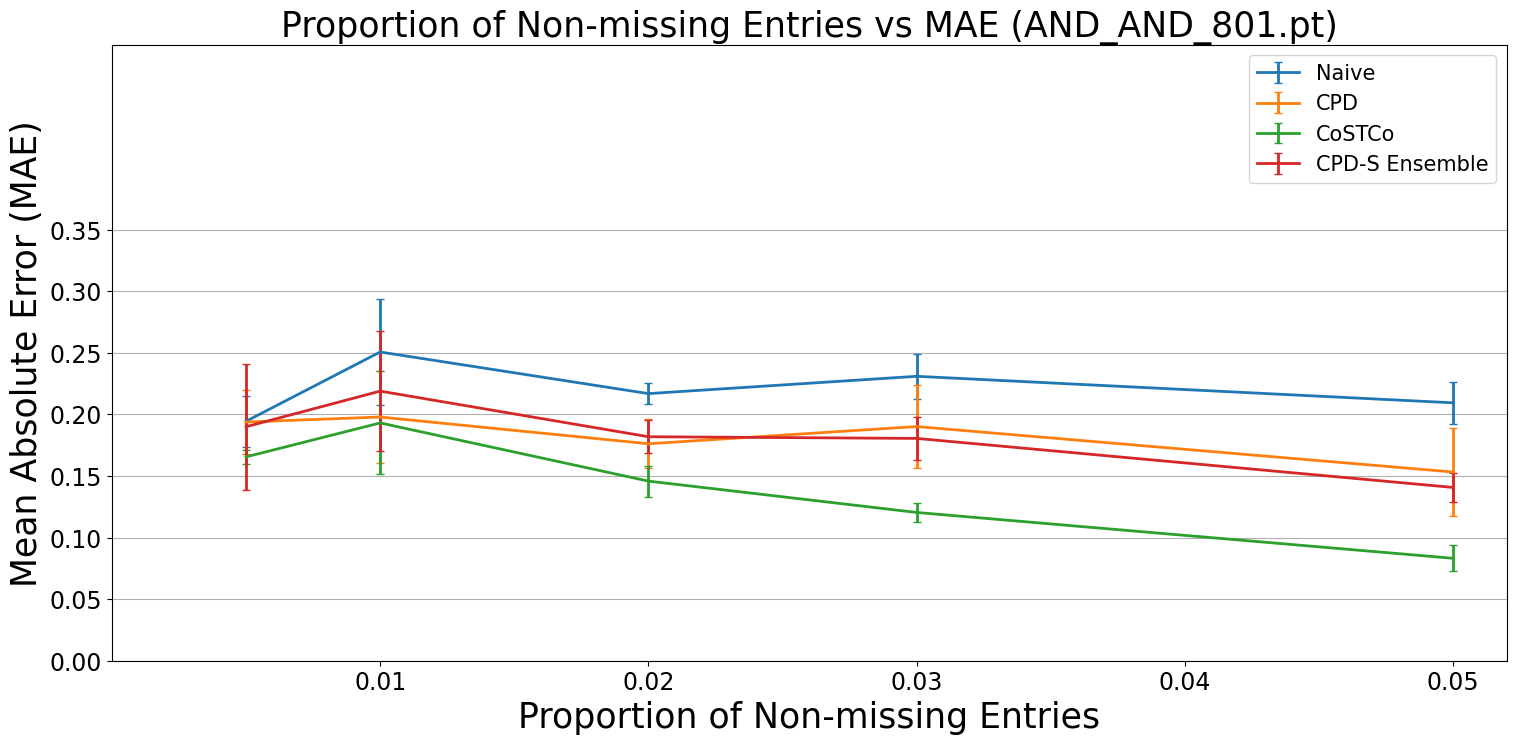

In [26]:
x = portions

plt.figure(figsize=(18, 8))
# plt.rcParams.update({'font.size':12})

for i in range(MAEs.shape[-1]):
    
    current_model = MAEs[:, :, :, i]
    
    current_model = current_model.min(axis = 2)
        
    plt.errorbar(x, current_model.mean(axis = 1), yerr=current_model.std(axis = 1), label=labels[i], capsize=3, linewidth=2)
    

plt.xlabel('Proportion of Non-missing Entries', fontsize=25)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=25)
plt.xticks([t/100 for t in range(1, 10+1)], fontsize=17)

plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize = 17)

if (file is None): file_s = ""
else: file_s = " (" + file + ".pt)"

plt.title(f'Proportion of Non-missing Entries vs MAE{file_s}', fontsize=25)
plt.legend(fontsize=15)
plt.grid(axis='y')

plt.xlim(0, x[-1]+(x[-1]/25))
# plt.ylim(0.1, 0.2)
plt.ylim(0, 0.5)
# plt.ylim(bottom = 0)

plt.show()